<a href="https://colab.research.google.com/github/glaserlab/LVM-Workshop/blob/main/nb3_dimensionality_sols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Some helper functions for Gaussians
from numpy.random import normal, multivariate_normal
from scipy.stats import norm

from scipy.linalg import orth

#Sci-kit linear factor analysis and PCA, Linear Regression, and IsoMap
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.linear_model import LinearRegression
from sklearn.manifold import Isomap

from sklearn.metrics import r2_score

## 1. Holding out test-set data during dimensionality reduction
In this problem, we'll explore why have a held-out test set that includes both held-out neurons and held-out timepoints is important. In particular, we'll demonstrate how the r2 values will keep increasing beyond the true dimensionality if you only hold out neurons or timepoints)

Here, we won't be doing full cross-validation (for the sake of simplicity), but will just be doing a train/test split.

A) We'll first simulate data generated from a 5-dimensional latent space (with random values), which is projected up to a 50-dimensional observation space through a random orthogoal matrix. Noise is added in the 50-dimensional space. The final neural data is "X", which is size timepoints x neurons. <br>
Just run the code below.

In [2]:
#Set the random seed so we get the same results every time
np.random.seed(0)

T=2000 #number of timepoints
num_latents=5 #number of latents
num_observations=50 #number of neurons (observations)

Z=np.random.randn(T,num_latents) #Random latents

U=orth(np.random.randn(num_observations,num_latents)).T #Random projection matrix

X=Z@U+1*np.random.randn(T,num_observations) #High-dimensional "neural" data

B) Just split training/testing based on time (not neurons):

*   Make the first half of time points the training and the second half testing
*   Fit PCA on the training data
*   Evaluate the fit on the testing data using "r2_score" (imported above)
*   Do this for all possible dimensionalities (1-50)
*   As the output at the end, create a plot of the r2 values as a function of the dimensionality.

We have provided some code that you can fill in to get started.


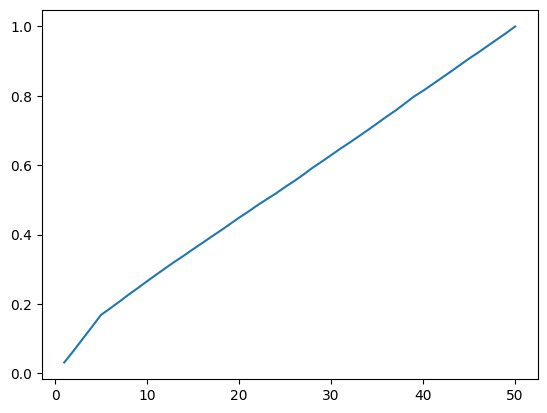

In [3]:
X_train=X[:int(T/2),:]
X_test=X[int(T/2):,:]

r2s=[]
for k in np.arange(1,num_observations+1):
  pca2=PCA(k)
  pca2.fit(X_train)

  X_test_hat=(X_test-pca2.mean_[None,:])@pca2.components_.T@pca2.components_+pca2.mean_[None,:]

  r2s.append(r2_score(X_test,X_test_hat))

plt.plot(np.arange(1,num_observations+1),r2s)

C) Just split training/testing based on neurons (not time):

*   Make the first half of neurons the training set and the second half testing
*   Fit PCA on the training neurons
*   Use linear regression to predict the test-set neurons from the PCs you just fit (based on the training neurons)
*   Evaluate the fit
*   Do this for all possible dimensionalities (1-25). Note that the top dimensionality you can test is 25, since we are splitting the neurons in half.
*   As the output at the end, create a plot of the r2 values as a function of the dimensionality.

We have provided some code that you can fill in to get started.


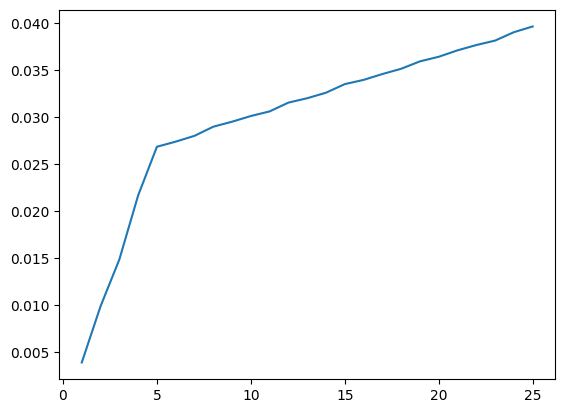

In [4]:

X_train=X[:,:int(num_observations/2)]
X_test=X[:,int(num_observations/2):]

r2s=[]
for k in np.arange(1,int(num_observations/2+1)):
  pca2=PCA(k)
  Z_pca=pca2.fit_transform(X_train)

  lr=LinearRegression()
  lr.fit(Z_pca,X_test)
  r2s.append(lr.score(Z_pca,X_test))

plt.plot(np.arange(1,int(num_observations/2+1)),r2s)

D) Split training/testing based on neurons and time:


*   First split the data into train/test based on neurons (as you did in C).
*   Fit PCA on the training neurons
*   Train a linear regression model to predict the test-set neurons from the PCs you just fit, *but only using the first half of time points (training time points)*
*   Evaluate the fit of this linear regression model on the testing time points
*   Do this for all possible dimensionalities (1-25). Note that the top dimensionality you can test is 25, since we are splitting the neurons in half.
*   As the output at the end, create a plot of the r2 values as a function of the dimensionality.

We have provided some code that you can fill in to get started.


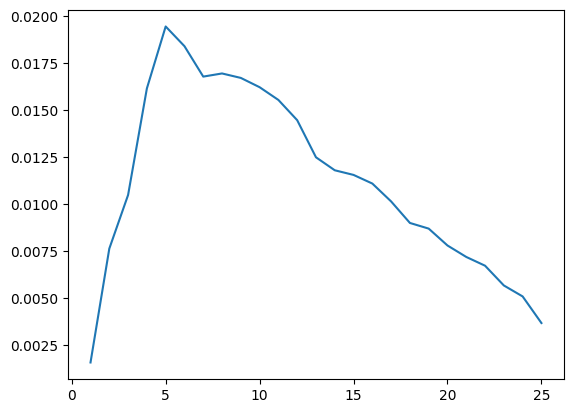

In [5]:
X_train_nrns=X[:,:int(num_observations/2)]
X_test_nrns=X[:,int(num_observations/2):]

r2s=[]
for k in np.arange(1,int(num_observations/2+1)):
  pca2=PCA(k)
  Z_pca=pca2.fit_transform(X_train_nrns)

  lr=LinearRegression()
  lr.fit(Z_pca[:int(T/2),:],X_test_nrns[:int(T/2),:])
  r2s.append(lr.score(Z_pca[int(T/2):,:],X_test_nrns[int(T/2):,:]))

plt.plot(np.arange(1,int(num_observations/2+1)),r2s)

Note that estimating the exact dimensionality will generally be improved with cross-validation than with a single train/test split (above it underestimates the dimensionality as 4, but when the random seed is seed to 1 it overestimates the dimensionality)

## 2) Nonlinear and linear dimensionality reduction

Below is an overly simplistic simulation of place cell activity as an animal runs along a 1 dimensional trajectory at a constant pace. <br>
Each neuron has a place cell with a Gaussian tuning curve centered at a different place along the track.
<br>
Let's see how linear and nonlinear dimensionality reduction methods compare

In [6]:
#Number of neurons recorded
num_nrns=20

#Locations that the animal runs at each time step
xs=np.arange(start=0,stop=21,step=.01)

#Centers of all the tuning curves
mus=np.arange(1,num_nrns+1)
#Standard deviation of the tuning curves
sigma=1

#Generate the neural activity for each neuron, and format it to be in a matrix of size timepoints (samples) x neurons
X=np.vstack([norm.pdf(xs,mus[i],sigma) for i in range(20)]).T

Run below to plot the tuning curves of some example neurons. <br>
Note that the plot both shows tuning curves as a function of location, and the neuron's activities as a function of time (since in this simulation we're assuming the animal is moving along this track at a constant speed)

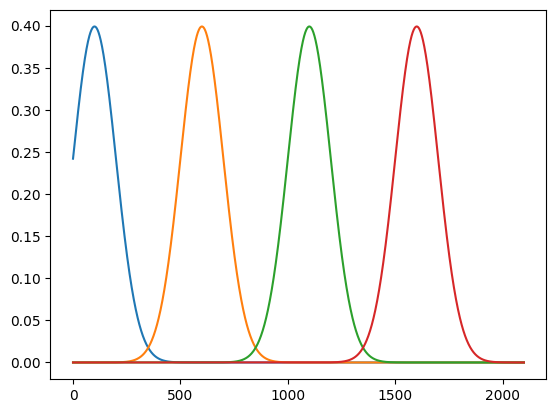

In [7]:
plt.plot(X[:,0])
plt.plot(X[:,5])
plt.plot(X[:,10])
plt.plot(X[:,15])

A) Run PCA on the above data with full dimensionality (20).

In [8]:
pca=PCA()
pca.fit(X)

PCA()

B) Plot the explained variance ratio, to get an intuition for the linear dimensionality of the data (i.e., that it seems high dimensional).

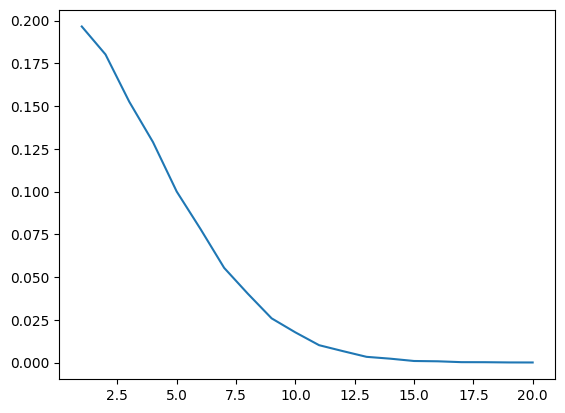

In [9]:
plt.plot(np.arange(1,21),pca.explained_variance_ratio_)

C) Plot the first 3 PCs as a function of time.

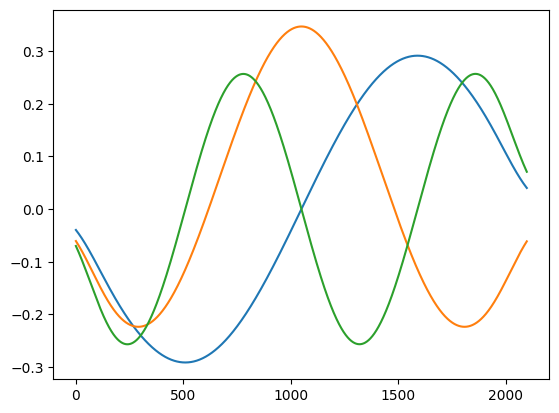

In [10]:
z_pca=pca.transform(X)
plt.plot(z_pca[:,:3])

D) The below code will run Isomap, a nonlinear dimensionality reduction technique, on the data. After running, plot the two dimensions of the data.

In [11]:
isomap=Isomap(n_components=2)
z_iso=isomap.fit_transform(X)

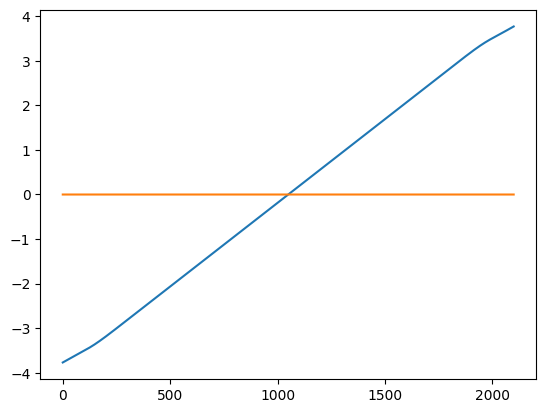

In [12]:
plt.plot(z_iso)

E) There is not a direct equivalent to the explained variance of the high-dimensional data for Isomap (it projects the data into a lowD space, but there is not a learned mapping back to the highD space). People do sometimes determine the variance in the lowD space, but that's not readily available as part of Isomap in scikit learn, so we won't be doing that :)
<br>
That being said, in the text box below, write the apparent nonlinear dimensionality of the system based on the above plot.

The nonlinear dimensionality is 1